In [1]:
### imports

# external modules
import os
from os.path import exists
import os.path
import pandas as pd
import json
import sys
from sys import getsizeof
import itertools
import numpy as np
import matplotlib.pyplot as plt
import importlib
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import FlexiStruct
importlib.reload(FlexiStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-06-29 22:18:06.245440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
year = '2017'
era = 'B'

datadir = '../data/' + year + era + '/'

In [3]:
blk1Vars = ['chargeInner', 'chargeOuter', 'adc', 'size']
blk2Vars = ['NormalizedHitResiduals', 
            'Summary_ClusterStoNCorr__OnTrack_',
            #'Summary_TotalNumberOfDigis_'
           ]
blk3Vars = [
    #'NumberOfTracks', 
    'NumberOfRecHitsPerTrack', 
    'Chi2oNDF',
    'goodvtxNbr'] 
miscVars = [
    #'NumberOfClustersInPixel', 
    'num_clusters_ontrack_PXBarrel', 
    'num_clusters_ontrack_PXForward', 
    #'NumberOfClustersInStrip'
]

In [4]:
### Get the different permutations for block 1
combosBlk1 = []
histcount = 0
modelcount = 0
for size in range(1, len(blk1Vars) + 1):
    # Get every combination of given size
    thisList = list(itertools.combinations(blk1Vars, size))
    
    
    ## Applying rules
    for item in thisList:
        
        if 'chargeInner' not in item: continue
        
        subList = []
        subListPX = []
        subListDSP = []
        subListDSN = []
        # Getting individual histograms to set appropriate names
        for element in item:
            
            # Need to treat chargeInner the same as 'charge' for disks
            if element == 'chargeInner':
                for i in range(1, 4):
                    subListDSP.append('charge_PXDisk_+' + str(i))
                    subListDSN.append('charge_PXDisk_-' + str(i))
                    
            elif element != 'chargeOuter':
                for i in range(1, 4):
                    subListDSP.append(element + '_PXDisk_+' + str(i))
                    subListDSN.append(element + '_PXDisk_-' + str(i))
            # PXlayers
            for i in range(1, 5):
                subListPX.append(element + '_PXLayer_' + str(i))
        
        subList.append(subListPX)
        subList.append(subListDSP)
        subList.append(subListDSN)
        
        combosBlk1.append(subList)

In [5]:
### Permutations for block 2
combosBlk2 = []
for size in range(1, len(blk2Vars) + 1):
    # Get every combination of given size
    thisList = list(itertools.combinations(blk2Vars, size))
    
    
    ## Applying rules
    for item in thisList:
        if 'Summary_ClusterStoNCorr__OnTrack_' not in item: continue
            
        subList = []
        subTIB = []
        subTOB = []
        subTIDP = []
        subTIDN = []
        subTECP = []
        subTECN = []
        
        # Getting individual histograms to set appropriate names
        for element in item:
            
            # Special case
            if element != 'NormalizedHitResiduals':
                for i in range(1, 10):
                    subTECN.append(element + '_TEC__MINUS__wheel__' + str(i))
                    subTECP.append(element + '_TEC__PLUS__wheel__' + str(i))
                    
                for i in range(1, 4):
                    subTIDN.append(element + '_TID__MINUS__wheel__' + str(i))
                    subTIDP.append(element + '_TID__PLUS__wheel__' + str(i))
                    
                for i in range(1, 5):
                    subTIB.append(element + '_TIB__layer__' + str(i))
            
                for i in range(1, 7):
                    subTOB.append(element + '_TOB__layer__' + str(i))
                    
            else: 
                for i  in range(1, 10):
                    subTECN.append(element + '_TEC__wheel__' + str(i))
                    
                for i in range(1, 4):
                    subTIDN.append(element + '_TID__wheel__' + str(i))
                    
                for i in range(1, 5):
                    subTIB.append(element + '_TIB__Layer__' + str(i))
            
                for i in range(1, 7):
                    subTOB.append(element + '_TOB__Layer__' + str(i))

        subList.append(subTIB)
        subList.append(subTOB)
        if len(subTIDP) > 0:
            subList.append(subTIDP)
        subList.append(subTIDN)
        if len(subTECP) > 0:
            subList.append(subTECP)
        subList.append(subTECN)
        combosBlk2.append(subList)

In [6]:
### Permutations for block 3
combosBlk3 = []

for size in range(1, len(blk3Vars) + 1):
    # Get every combination of given size
    thisList = list(itertools.combinations(blk3Vars, size))
    
    ## Applying rules
    for item in thisList:
        if 'NumberOfRecHitsPerTrack' not in item: continue
         
        subList = []
        for element in item:
            if element !='goodvtxNbr':
                subList.append(element + '_lumiFlag_GenTk')
            else:
                subList.append(element)
        
        combosBlk3.append([subList])

In [7]:
### Permutations for block 4
combosBlk4 = []

for size in range(0, len(miscVars) + 1):
    # Get every combination of given size
    thisList = list(itertools.combinations(miscVars, size))
    
    ## Applying rules
    for item in thisList:
        subList = []
        subSubList = []
        for element in item:
            subSubList.append(element)
    
        subList.append(subSubList)
        combosBlk4.append(subList)

In [8]:
### Parsing combinations to create histlists
histlists = []
conmodelcount = 0
combmodelcount = 0
for combo1 in combosBlk1:
    for combo2 in combosBlk2:
        for combo3 in combosBlk3:
            for combo4 in combosBlk4:
                curList = []
                for element in combo1:
                    curList.append(element)
                for element in combo2:
                    curList.append(element)
                for element in combo3:
                    curList.append(element)
                for element in combo4:
                    if len(element) > 0:
                        curList.append(element)
                
                # Sanity check that all files exist
                for histgroup in curList:
                    for hist in histgroup:
                        filename = 'DF' + year + era + '_' + hist +'.csv'
                        path = datadir + filename
                        if not os.path.exists(path):
                            raise Exception('Histogram {} does not exist!'.format(hist))
                histlists.append(curList)
                
for histlist in histlists:
    for histgroup in histlist:
        conmodelcount = conmodelcount + 1
        for hist in histgroup:
            combmodelcount = combmodelcount + 1
            
print('Models to Train:')
print(' - Concatamash: ' + str(conmodelcount))
print(' - Combined: ' + str(combmodelcount))

print('\nTraining Sets: ' + str(len(histlists)))
print()

Models to Train:
 - Concatamash: 2752
 - Combined: 17920

Training Sets: 256



In [9]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Select a list of good runs to train on in development training_mode
# Should be validated by eye
trainrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                   "297598":[[-1]],
#                   "297604":[[-1]],   # A decently clean histogram
                   "297620":[[-1]],   # A decently clean histogram
                   "297659":[[-1]],   # An okay histogram
                   "297670":[[-1]],   # A decently clean histogram
#                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
#                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                   "299065":[[-1]],   # A decently clean histogram
                   "299067":[[-1]],   # A decently clean histogram
                   "299096":[[-1]],
                   "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
#                    "299185":[[-1]],   # A decently clean histogram
#                    "299327":[[-1]],
#                    "299329":[[-1]], 
#                    "299480":[[-1]]    # A decently clean histogram
                    },
                   '2017C': {
#                      "299370":[[-1]],
#                      "299394":[[-1]],
#                      "299420":[[-1]],
#                      "299477":[[-1]],
#                      "299593":[[-1]],
#                      "299597":[[-1]],
#                      "299617":[[-1]],
#                      "300018":[[-1]],
#                      "300105":[[-1]],
#                      "300117":[[-1]],
#                      "300124":[[-1]],
#                      "300234":[[-1]],
#                      "300237":[[-1]],
#                      "300240":[[-1]],
#                      "300370":[[-1]],
#                      "300157":[[-1]],
#                      "300373":[[-1]],
#                      "300392":[[-1]],
#                      "300395":[[-1]],
#                      "300401":[[-1]],
#                      "300462":[[-1]],
#                      "300466":[[-1]],
                      "300514":[[-1]],
                      "300517":[[-1]],
                      "300538":[[-1]],
                      "300539":[[-1]],
                      "300364":[[-1]],
                 },'2017F':{
#                      "305310":[[-1]],
#                      "305040":[[-1]],
#                      "305043":[[-1]],
#                      "305185":[[-1]],
#                      "305204":[[-1]],
                      "305234":[[-1]],
                      "305247":[[-1]],
                      "305313":[[-1]],
                      "305338":[[-1]],
                      "305350":[[-1]],
                      "305364":[[-1]],
                      "305376":[[-1]],
                      "306042":[[-1]],
                      "306051":[[-1]],
                      "305406":[[-1]],
                      "306122":[[-1]],
                      "306134":[[-1]],
                      "306137":[[-1]],
                      "306154":[[-1]],
                      "306170":[[-1]],
                      "306417":[[-1]],
                      "306432":[[-1]],
                      "306456":[[-1]],
                      "305516":[[-1]],
                      "305586":[[-1]],
                      "305588":[[-1]],
                      "305590":[[-1]],
                      "305809":[[-1]],
                      "305832":[[-1]],
                      "305840":[[-1]],
                      "305898":[[-1]],
                      "306029":[[-1]],
                      "306037":[[-1]],
                      "306095":[[-1]],
                },
                '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}

# Select a list of good runs to test on in development training_mode
# Should be validated by eye
goodrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                    "297598":[[-1]],
#                    "297604":[[-1]],   # A decently clean histogram
#                    "297620":[[-1]],   # A decently clean histogram
                    "297659":[[-1]],   # An okay histogram
                    "297670":[[-1]],   # A decently clean histogram
                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                    "299065":[[-1]],   # A decently clean histogram
                    "299067":[[-1]],   # A decently clean histogram
#                    "299096":[[-1]],
#                    "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
                    "299185":[[-1]],   # A decently clean histogram
                    "299327":[[-1]],
#                    "299329":[[-1]], 
                    "299480":[[-1]]    # A decently clean histogram
                    },
                '2017C':{
#                      "299370":[[-1]],
#                      "299394":[[-1]],
#                      "299420":[[-1]],
#                      "299477":[[-1]],
#                      "299593":[[-1]],
#                      "299597":[[-1]],
#                      "299617":[[-1]],
#                      "300018":[[-1]],
#                      "300105":[[-1]],
#                      "300117":[[-1]],
#                      "300124":[[-1]],
#                      "300234":[[-1]],
#                      "300237":[[-1]],
#                      "300240":[[-1]],
#                      "300370":[[-1]],
#                      "300157":[[-1]],
#                      "300373":[[-1]],
#                      "300392":[[-1]],
#                      "300395":[[-1]],
#                      "300401":[[-1]],
#                      "300462":[[-1]],
#                      "300466":[[-1]],
                      "300514":[[-1]],
                      "300517":[[-1]],
                      "300538":[[-1]],
                      "300539":[[-1]],
                      "300364":[[-1]],
                },'2017F':{
                      "305310":[[-1]],
                      "305040":[[-1]],
                      "305043":[[-1]],
                      "305185":[[-1]],
                      "305204":[[-1]],
#                      "305234":[[-1]],
#                      "305247":[[-1]],
#                      "305313":[[-1]],
#                      "305338":[[-1]],
#                      "305350":[[-1]],
#                      "305364":[[-1]],
#                      "305376":[[-1]],
#                      "306042":[[-1]],
#                      "306051":[[-1]],
#                      "305406":[[-1]],
#                      "306122":[[-1]],
#                      "306134":[[-1]],
#                      "306137":[[-1]],
#                      "306154":[[-1]],
#                      "306170":[[-1]],
#                      "306417":[[-1]],
#                      "306432":[[-1]],
#                      "306456":[[-1]],
#                      "305516":[[-1]],
#                      "305586":[[-1]],
#                      "305588":[[-1]],
#                      "305590":[[-1]],
#                      "305809":[[-1]],
#                      "305832":[[-1]],
#                      "305840":[[-1]],
#                      "305898":[[-1]],
#                      "306029":[[-1]],
#                      "306037":[[-1]],
#                      "306095":[[-1]],
                },
                '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}


badrunsls = {'2017B':
                {
                    #"297048":[[-1]],
                    #"297282":[[-1]],
                    #"297283":[[-1]],
                    #"297284":[[-1]],
                    #"297287":[[-1]],
                    #"297288":[[-1]],
                    #"297289":[[-1]],
                    "299316":[[-1]],
                    "299317":[[-1]],
                    "299318":[[-1]],
                    "299324":[[-1]],
                    "299326":[[-1]],
                    #"301086":[[88,126]],
                    #"301086":[[89,89]],
                    #"303948":[[1710,1710]],
                    "297047":[[-1]], #close but, true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297211":[[-1]], #Reconstructs well
#                   "299325":[[-1]], #Reconstructs well
                    "297664":[[-1]], #true bad for all 8
                    "299317":[[-1]], #true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297502":[[-1]]
                },
             '2017C':{
                "300079":[[-1]],
                "300282":[[-1]],
                "300389":[[-1]],
                "300398":[[-1]],
                 
                 
#                 "300781":[[-1]], # bad for tracking (pixels were excluded.
#                 "300079":[[-1]], # is bad for strips and then also for tracking
#                 "302029":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good 
#                 "300576":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "300574":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "300282":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "301912":[[-1]], # Half bad for pixels (lost HV or readout card)  
#                 "301086":[[-1]], # Half bad for pixels (lost HV or readout card)  
#                 "300283":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300282":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300281":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300239":[[-1]], # Half bad for pixels (lost HV or readout card)
#                 "301394":[[-1]], # Marginal for pixels
#                 "301183":[[-1]], # Marginal for pixels
#                 "300398":[[-1]], # Marginal for pixels
#                 "300389":[[-1]], # Marginal for pixels
#                 "300365":[[-1]]  # Marginal for pixels
              },
             '2017E':{
                 "304740":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304776":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304506":[[-1]], # Portcard problem for pixels
                 "304507":[[-1]], # Portcard problem for pixels 
                 "303989":[[-1]], # Bad for pixels, power supply died
                 "303824":[[-1]]  # Partly bad for strips due to a test
             },
             '2017F':{
                 "306422":[[-1]], # Partly bad for strips - 2 data readouts failed 
#                 "306423":[[-1]], # Partly bad for strips - 2 data readouts failed
#                 "306425":[[-1]], # Partly bad for strips - 2 data readouts failed
#                 "305440":[[-1]], # Partly bad for strips - 1 data readout failed
#                 "305441":[[-1]], # Partly bad for strips - 1 data readout failed
                 "305249":[[-1]], # Bad for pixels - half of disk failed 
                 "305250":[[-1]], # Bad for pixels - half of disk failed
#                 "305064":[[-1]], # Marginal for pixels - some readout failed
             },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = histlists[255]

In [10]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Select whether to save a new histstruct
save = False

In [11]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

# Bias Factors
fmBiasFactor = 2
wpBiasFactor = 20

In [12]:
# train on a user-defined subset of runs
    
# Select runs to be used in training from the user-defined list
runsls_training = trainrunsls[year + era]
# Select bad runs to test on in the user-defined list
runsls_bad = badrunsls[year + era]
# Select good runs to test on in the user-defined list
runsls_good = goodrunsls[year + era]


In [13]:
# Initializations
dloader = DataLoader.DataLoader()
histstruct = FlexiStruct.FlexiStruct()
histstruct.reset_histlist(histnames)

# Unpack histnames and add every histogram individually
for histnamegroup in histnames:
    for histname in histnamegroup:
        
        # Bring the histograms into memory from storage for later use
        filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
        df = dloader.get_dataframe_from_file( filename )
        
        # In case of local training, we can remove most of the histograms
        if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
            runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
            df = dfu.select_runsls( df, runsls_total )
        
        df = dfu.rm_duplicates(df)
        
        try:
            # Store the data in the histstruct object managing this whole thing
            histstruct.add_dataframe( df, rebinningfactor = 1, standardbincount = 102 )
        except:
            print("WARNING: Could not add " + histname, file=sys.stderr)

In [14]:
### Add Masks to Data
def assignMasks(histstruct, runsls_training, runsls_good, runsls_bad):

    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat', entries_to_bins_ratio=0)
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=0)
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
    return histstruct

In [15]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            # Half the total bin count
            arch = 51 * len(histnamegroup)
            
            ## Model parameters
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(arch * 2, activation="tanh")(conc_layer)
            encoder = Dense(arch, activation='relu')(encoder)
            
            encoder = Dense(arch/2, activation='relu')(encoder)
            
            decoder = Dense(arch, activation="relu")(encoder)
            decoder = Dense(arch * 2, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
    # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
    return(histslist, vallist, autoencoders, train_normhist)

In [16]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    autoencodersTrain = []
    for i in range(len(histslist)):
        
        sys.stdout.write('\rNow training model {}/'.format(i + 1) + str(len(histslist)))
        sys.stdout.flush()
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 500
        batch_size = 1000
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=0,
                            callbacks= [earlystop],    
                            )
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier) 
        autoencodersTrain.append(classifier)
    return autoencodersTrain

In [17]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        histstruct.evaluate_classifier(histgroup)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histgroup in histnames:
            for histname in histgroup:
                mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histgroup in histnames:
            for histname in histgroup:
                hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
                thismse = histstruct.classifiers[histname].evaluate( hists_good )
                mse_good.append( thismse )
                print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    
    # get mse for bad sets
    mse_bad = []
    nbadruns = len([name for name in runsls_bad])
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        
    return [mse_train, mse_good, mse_bad]

In [18]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = len(histstruct.histnames)
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    fitfunc = GaussianKdeFitter.GaussianKdeFitter()
    fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [19]:
### Prepare MSEs for Working Point Definition
def mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    #print(sorted(logprob_good))

    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))

    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    #print(logprob_bad)
    
    sep = np.min(logprob_good) - np.max(logprob_bad)
    
    return [logprob_good, logprob_bad, sep]

In [20]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    # Note this will give an error if there are all infinities in one or both arrays
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, np.inf))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, -np.inf))
    
    # Getting rid of infinities
    logprob_good[logprob_good > 500] = goodMax
    logprob_bad[logprob_bad < 0] = badMin
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good < badMin] = badMin
    logprob_bad[logprob_bad > goodMax] = goodMax
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 424
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    return [logprob_threshold, f_measure, avSep]

Running Job 1/256 - 0.00% Complete


2022-06-29 22:19:33.613157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc

Now training model 1/10

2022-06-29 22:19:34.623786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-29 22:19:34.624675: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Training complete in 54.83618578501046 seconds
New Best Model:
 - Train Time: 54.83618578501046
 - Separability: 33.087035061732955
 - F2-Measure: 0.7449368049034205

Running Job 2/256 - 0.36% Complete
Training complete in 62.67634505033493 seconds
New Best Model:
 - Train Time: 62.67634505033493
 - Separability: 40.659088003721614
 - F2-Measure: 0.745730583705217

Running Job 3/256 - 0.76% Complete
Training complete in 72.75059962738305 seconds

Running Job 4/256 - 1.16% Complete
Training complete in 66.20953614171594 seconds

Running Job 5/256 - 1.56% Complete
Training complete in 48.084880601614714 seconds
New Best Model:
 - Train Time: 48.084880601614714
 - Separability: 42.681075973590026
 - F2-Measure: 0.7468247957517691

Running Job 6/256 - 1.93% Complete
Training complete in 66.49522927775979 seconds

Running Job 7/256 - 2.33% Complete
Training complete in 61.50497513636947 seconds

Running Job 8/256 - 2.73% Complete
Training complete in 63.008943842723966 seconds

Running Job 

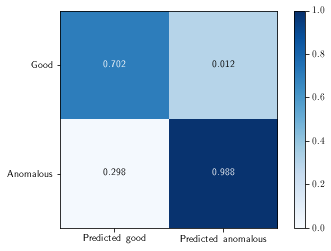

In [21]:
### Main loop to iterate through possible histlists
userfriendly = True
top50 = []
numModels = 0
for i,histnames in enumerate(histlists[:10]):
    percComp = (numModels/conmodelcount)*100
    print('Running Job {}/'.format(i+1) + str(len(histlists)) + ' - {:.2f}% Complete'.format(percComp))
    
    # Update histlist to reflect new data
    histstruct.reset_histlist(histnames, suppress=True)
    assignMasks(histstruct, runsls_training, runsls_good, runsls_bad)
    
    # Build autoencoders based on new data
    (histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)
    
    # Train autoencoders based on current histlist and record speed
    start = time.perf_counter()
    
    # Suppres Unhelpful Error Messages
    orig_out = sys.stderr
    sys.stderr = open('trash', 'w')
    autoencoders = train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)
    sys.stderr = orig_out
    
    numModels += len(autoencoders)
    
    stop = time.perf_counter()
    trainTime = stop - start
    
    sys.stdout.write('\rTraining complete in ' + str(trainTime) + ' seconds')
    sys.stdout.flush()
    print()
    
    # Evaluate models
    (mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)
    fitfunc = fit_mse_distribution(histstruct, mse_train)
    
    orig_out = sys.stderr
    sys.stderr = open('trash', 'w')
    (logprob_good, logprob_bad, sep) = mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc)
    sys.stderr = orig_out
    
    (logprob_threshold, f_measure, avSep) = evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor)
    
    # Adding a penalty for unseparable autoencoders
    if(sep <= 0): sepFactor = 0.7
    else: sepFactor = 1
    
    # Metric to determine how separable our dataset is
    separability = sepFactor*avSep
    
    # Empty list
    dataPackage = [histnames, autoencoders, trainTime, separability, sep, f_measure, logprob_threshold]
    if len(top50) < 1:
        top50.append(dataPackage)
        print('New Best Model:')
        print(' - Train Time: ' + str(trainTime))
        print(' - Separability: ' + str(separability))
        print(' - F{}-Measure: '.format(fmBiasFactor) + str(f_measure))
        
    # Partly full list
    elif len(top50) < 50:
        for j in range(len(top50) - 1, -1, -1):
            if separability < top50[j][3]:
                top50.insert(j+1, dataPackage)
                break
            # Reached end of list
            if j == 0:
                top50.insert(j, dataPackage)
                print('New Best Model:')
                print(' - Train Time: ' + str(trainTime))
                print(' - Separability: ' + str(separability))
                print(' - F{}-Measure: '.format(fmBiasFactor) + str(f_measure))
               
    # Full list
    elif separability > top50[49]:
        for j in range(49, -1, -1):
            if separability < top50[j][3]:
                top50.insert(j+1, dataPackage)
                break
                
            # Reached end of list
            if j == 0:
                top50.insert(j, dataPackage)
                print('New Best Model:')
                print(' - Train Time: ' + str(trainTime))
                print(' - Separability: ' + str(separability))
                print(' - F{}-Measure: '.format(fmBiasFactor) + str(f_measure))
            
            
        del top50[-1]
    del(f_measure)
    K.clear_session()
    
    print()

In [23]:
for i,list in enumerate(top50):
    print(list[2:])
    autoencoders = list[1]
    for j, autoencoder in enumerate(autoencoders):
        autoencoder.save('../SavedModels/Permutations/Job' + str(i + 1) + '/AE' + str(j))

[48.084880601614714, 42.681075973590026, -32.55251278192134, 0.7468247957517691, 381.6441434689159]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the funct

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job1/AE8/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job2/AE2/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job3/AE0/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job3/AE4/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job4/AE2/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job4/AE6/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job5/AE4/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job6/AE6/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

[54.83618578501046, 33.087035061732955, -26.803816176612656, 0.7449368049034205, 375.4499332381984]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the funct

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job7/AE8/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job8/AE2/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job9/AE0/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job9/AE4/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograp

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job10/AE2/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autogra

INFO:tensorflow:Assets written to: ../SavedModels/Permutations/Job10/AE6/assets
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autogra